# Learning to Learn w\ Quantum NN via Classical NN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stfnmangini/QOSF-Mentorship/blob/main/l2l_1.ipynb)

This it the first jupyter notebook used to familiarize with _Pennylane_ and _RNNs_ and _LSTMs_.

At first, the QAOA example for MAXCUT will be implemented.

**Run cell below only if using this notebook in Colab**  
Installing required dependencies and packages

In [ ]:
IS_COLAB = False
if IS_COLAB:
    !pip install --upgrade qiskit
    !pip install --upgrade pennylane
    !pip install networkx

#### Importation of required packages

In [1]:
import pennylane as qml
import numpy as np
from pennylane import qaoa

import tensorflow as tf

import networkx as nx
import matplotlib.pyplot as plt

# Set the seed for reproducibility of results
np.random.seed(42)
tf.random.set_seed(42)

## Generation of data: graphs

Let's generate some random graphs $G_{n,p}$ where:
- $n$ is the number of nodes in the graphs
- $p$ is the probability of creation of an edge between two nodes

In [2]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """
    Generate a list containing random graphs generated by Networkx. 
    
    Args:
    n_graphs: length of final list. Number of graphs to generate.
    n_nodes: number of nodes in each graph.
    p_edge: probability of having an edge between two nodes. (See Networkx's documentation)
    
    Returns:
    datapoints: list containing the generated graphs
    """
    
    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p = p_edge)
        datapoints.append(random_graph)
    return datapoints

An example of random graph

Sample of a generted graph with 7 nodes and 7 edges (p=0.43)


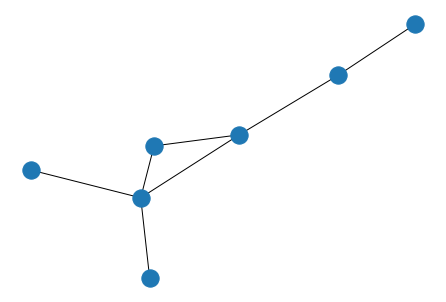

In [3]:
# Define parameters of the graph
n_graphs = 100
n_nodes = 7
p_edge = 3./n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

print(f"Sample of a generted graph with {len(graphs[0].nodes)} nodes and {len(graphs[0].edges)} edges (p={p_edge:.2f})")
nx.draw(graphs[0])

## Creating QAOA circuit

In [4]:
def qaoa_from_graph(graph, n_layers = 1):
    """
    Creates a QAOA circuit instance of the MaxCut problem given a graph. Has nested function definitions needed for
    the creation of the circuit. When called, it instantiate a the structure of the circuit given the input graph,
    and outputs a function which needs only the parameters to be evaluated. 
    
    Args
    ------
    graph: Graph coming generated with Networkx.
    n_layers: number of repetitions for the QAOA ansatz.
    
    Return
    ------
    hamiltonian: A function which, given some parameters as input, evaluates the cost function of the 
    QAOA qautntum circuit for a specified graph.
    """
        
    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))
    
    # Define the structure of the cost and mixer subcircuits
    cost_h, mixer_h = qaoa.maxcut(graph)   
    
    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
       
    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs): 
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
     
    # Evaluates the cost function
    def hamiltonian(params, **kwargs):
        """
        Function that evaluates the cost of the QAOA, given the angles for the circuit and the specified graph. 
        
        Args:
        params: Parameters for the QAOA circuit, with shape [[alphas, gammas], ..., n_layers]. And len(alphas)=n_nodes
        
        Returns:
        cost: cost hamiltonian evaluated with the input parameters.
        
        """
        # We set the default.qubit.tf device for seamless integration with Tensorflow
        dev = qml.device('default.qubit.tf', wires=len(graph.nodes))
        # ExpvalCost evaluates the Expectation value of an operator on a circuit
        cost = qml.ExpvalCost(circuit, cost_h, dev, interface="tf",  diff_method = "backprop")
        return cost(params)
    
    return hamiltonian

#### First steps

Let's see how to use these functions.

In [5]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph = graphs[0], n_layers = 1)

# Define some paramenters, in the form [[gamma, alpha]]. 
x = tf.Variable([[0.5], [0.5]], dtype = tf.float32)

# Evaluate th QAOA instance just created with some angles.
cost(x)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-2.05494322])>

Now we optimize the parameters to reduce the cost function. We can do this using the `tf.GradientTape()`, thanks to Pennylane seamless integration with Tensorflow.

In [6]:
x = tf.Variable([[0.5], [0.5]], dtype = tf.float32)

# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# Choose the number of optimization steps
step = 15

# Start of optimization (or training)
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = cost(x)
        
    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_} - Loss = {loss}")
    
print(f"Final cost function: {cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 0 - Loss = [-2.05494322]
Step 1 - Loss = [-2.51953678]
Step 2 - Loss = [-3.05233223]
Step 3 - Loss = [-3.47188046]
Step 4 - Loss = [-3.64773877]
Step 5 - Loss = [-3.64981314]
Step 6 - Loss = [-3.66903811]
Step 7 - Loss = [-3.76827224]
Step 8 - Loss = [-3.91327568]
Step 9 - Loss = [-4.05350738]
Step 10 - Loss = [-4.16298653]
Step 11 - Loss = [-4.25546441]
Step 12 - Loss = [-4.36409165]
Step 13 - Loss = [-4.50453547]
Step 14 - Loss = [-4.65995898]
Final cost function: [-4.79202476]
Optimized angles: [[0.6104711]
 [1.2724065]]


## The Recurrent Neural Network architecture  

So far, we have defined function which let us build the QAOA algorithm for solving the Maxcut problem of a graph. Now we wish to devise a way to implement an optimzier which finds a good candidate for the angles in the QAOA quantum circuits for minimizing the cost function of the maxcut problem of the graph. We do this using a Recurrent Neural Network, in particular a customized model of an LSTM (Long-Short Term Memory). For this task, we will use `Keras` and `Tensorflow`.  

Let's define the elemental building block of the model, that is an LSTM cell (see [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell)).

In [7]:
# Number of layers in QAOA ansatz. The higher the better, but also more computationally hard.
n_layers = 1

# Define a single LSTM cell
cell = tf.keras.layers.LSTMCell(2*n_layers)

Let's create a list of cost functions given a list of graphs, using the `qaoa_from_graph` function.

In [8]:
graph_cost_list = [qaoa_from_graph(g) for g in graphs[:100]]

In [9]:
def rnn_iteration(inputs, graph_cost, n_layers = 1):
    """
    This function performs a single time step in the computational graph. Takes a graph and initial angles, and then 
    goes through a Keras' LSTM cell and the evaluated a cost function. 
    
    Args:
    inputs: List of different inputs from the previous timestep: cost functio, parameters, first hidden state,
    second hidden state. 
    graph_cost: cost function of a graph coming from the qaoa_from_graph function.
    
    Returns:
    New values for the cost, parameters, and hidden states. 
    """
    
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]
    
    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
        
    # New parameters obtained by the LSTM cell, along with new internal states: h and c
    new_params, [new_h, new_c] = cell(new_input, states = [prev_h, prev_c])
             
    # This part is used to feed the parameters to the Pennylane function
    _params = tf.reshape(new_params, shape = (2, n_layers))
             
    # Cost evaluation, and reshaping to be consistent with other Keras tensors
    #_cost = tf.py_function(graph_function, inp = [_params], Tout=tf.float64)
    _cost = graph_cost(_params)
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape = (1,1))
    
    return [new_cost, new_params, new_h, new_c] 

def recurrent_loop(graph_cost, n_layers = 1, intermediate_steps = False):
    """
    This function actually creates the recurrent architecure, connecting multiple iterations of the custom LSTM model.
    
    Args:
    graph_cost: cost function of a graph coming from the qaoa_from_graph function.
    intermediate_steps: set to True if you wish values from intermediate iterations.

    Returns:
    loss: Loss function driving the minimization process. 
    """
    # Initialize starting inputs as all zeros.
    initial_cost = tf.zeros(shape = (1, 1))
    initial_params = tf.zeros(shape = (1, 2*n_layers))
    initial_h = tf.zeros(shape = (1, 2*n_layers))
    initial_c = tf.zeros(shape = (1, 2*n_layers))
    
    # We perform five recurrent iterations. Feel free to increase or reduce it.  
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)
    
    # This cost function takes into account the cost from all iteration but using different wehgits. 
    loss = tf.keras.layers.average([0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]])
    
    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], loss]
    else:
        return loss

Here we define a single step in the training (optimization) process.

In [10]:
def train_step(graph_cost):
    """
    Iteration in the optimization/training loop. Given the cost/circuit of a graph, it evaluates the
    corresponding loss and eventually computes the gradients and update of the prameters.
    
    Args:
    graph_cost: cost function of a graph coming from the qaoa_from_graph function.
    
    Returns:
    loss: loss for the specified graph, for current value of the parameters.
    
    """
    with tf.GradientTape() as tape:
        loss = recurrent_loop(graph_cost)
    grads = tape.gradient(loss, cell.trainable_weights)
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

## Optimization Loop

For the optimization, we perform a stochastic gradient descent in the parameter space. For each graph in the training set, we evaluate the gradients and update the weights accordingly. Then, we repeat this procedure for multiple times (epochs).

In [11]:
# Select an optimized 
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f"------\n >  Mean Loss: {np.mean(total_loss)}")

Epoch 0
 > Graph 0/100 - Loss: -1.095945954322815
 > Graph 5/100 - Loss: -1.766568899154663
 > Graph 10/100 - Loss: -1.8782565593719482
 > Graph 15/100 - Loss: -1.2866551876068115
 > Graph 20/100 - Loss: -1.245526909828186
 > Graph 25/100 - Loss: -1.9543864727020264
 > Graph 30/100 - Loss: -1.303978681564331
 > Graph 35/100 - Loss: -1.4611871242523193
 > Graph 40/100 - Loss: -1.9477695226669312
 > Graph 45/100 - Loss: -2.2638039588928223
 > Graph 50/100 - Loss: -1.2655351161956787
 > Graph 55/100 - Loss: -1.5359779596328735
 > Graph 60/100 - Loss: -1.9093204736709595
 > Graph 65/100 - Loss: -1.6175569295883179
 > Graph 70/100 - Loss: -1.5823230743408203
 > Graph 75/100 - Loss: -2.0681025981903076
 > Graph 80/100 - Loss: -1.9283472299575806
 > Graph 85/100 - Loss: -1.8021434545516968
 > Graph 90/100 - Loss: -1.4618158340454102
 > Graph 95/100 - Loss: -2.5383715629577637
------
 >  Mean Loss: -1.726407328248024
Epoch 1
 > Graph 0/100 - Loss: -1.4539602994918823
 > Graph 5/100 - Loss: -1.

Note that the same machinery can be used for graphs having a different number of nodes. Let's create a dataset containing graphs having a number of nodes in the interval $n \in [7,9]$.

In [26]:
g7 = generate_graphs(10, 7, 3/7)
g8 = generate_graphs(10, 8, 3/7)
g9 = generate_graphs(10, 9, 3/7)

gs = g7+g8+g9
gs_cost_list = [qaoa_from_graph(g) for g in gs]

In [27]:
# Select an optimized 
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 3

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(gs_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i}/{len(gs_cost_list)} - Loss: {loss}")
    print(f" > Mean Loss: {np.mean(total_loss)}")

Epoch 0
 > Graph 0/100 - Loss: [[-1.2435602]]
 > Graph 5/100 - Loss: [[-1.5571034]]
 > Graph 10/100 - Loss: [[-1.7631152]]
 > Graph 15/100 - Loss: [[-2.7989807]]
 > Graph 20/100 - Loss: [[-2.9342427]]
 > Graph 25/100 - Loss: [[-3.8080506]]
 > Mean Loss: -2.254596296946208
Epoch 1
 > Graph 0/100 - Loss: [[-1.2460806]]
 > Graph 5/100 - Loss: [[-1.5977465]]
 > Graph 10/100 - Loss: [[-1.7737831]]
 > Graph 15/100 - Loss: [[-2.8268166]]
 > Graph 20/100 - Loss: [[-3.0138817]]
 > Graph 25/100 - Loss: [[-3.9591355]]
 > Mean Loss: -2.2909550110499066
Epoch 2
 > Graph 0/100 - Loss: [[-1.2468221]]
 > Graph 5/100 - Loss: [[-1.5990384]]
 > Graph 10/100 - Loss: [[-1.7777874]]
 > Graph 15/100 - Loss: [[-2.8236213]]
 > Graph 20/100 - Loss: [[-2.9467366]]
 > Graph 25/100 - Loss: [[-3.8228824]]
 > Mean Loss: -2.2735650221506756


These are optimized parameters for the LSTM cell:

In [28]:
optimized_weights = cell.get_weights()
print("Optimizer LSTM weights:\n")
optimized_weights

# To set initial weights for the cell, use:
# cell.set_weights(optimized_weights)

Optimizer LSTM weights:



[array([[-1.4990977 , -1.6186686 , -1.6079012 , -1.4279009 , -1.7163923 ,
          1.2226918 ,  0.2775383 ,  0.12405934],
        [ 0.8265473 ,  0.9897082 ,  0.79212624,  1.4582858 ,  0.36939698,
         -0.96255964, -0.69242704,  0.42092663],
        [-1.8966941 , -1.338229  , -0.84331644, -1.5420448 , -0.55026186,
          1.105887  , -0.6040543 ,  1.642047  ]], dtype=float32),
 array([[ 1.2750679 ,  1.5973562 ,  0.81222117,  0.9559596 ,  0.688454  ,
         -1.8477833 , -1.037921  , -0.4739683 ],
        [-1.5113798 , -1.434592  , -0.72621715, -1.043291  , -1.3425262 ,
          1.0954412 , -0.70966566,  1.696478  ]], dtype=float32),
 array([ 0.70145464, -0.15719399,  2.1610892 ,  2.1626966 ,  1.8296447 ,
        -1.6452899 ,  2.3302908 ,  1.171778  ], dtype=float32)]

# Performances

Let's check if this hybrid model eventually learnt a good heuristic to propose new updates for the parameters in the QAOA ansatz of the Maxcut problem.  
  

For this reason, we consider a new graph. In particular, we can take a graph with 10 nodes, which is something that the recurrent network has never seen before.

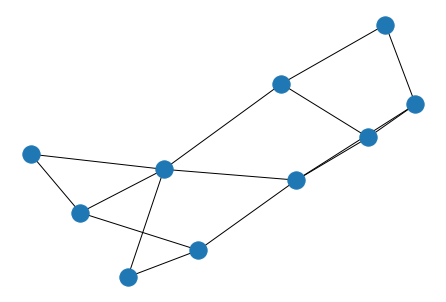

In [29]:
new_graph = nx.gnp_random_graph(10, p = 3/10)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

We call the trained recurrent LSTM on this graph, saving all intermediate guesses for the parameters, not only the last one. 

In [30]:
res = recurrent_loop(new_cost, intermediate_steps = True)

guess_0 = tf.zeros(shape = (2*n_layers, 1))
guess_1 = res[0]
guess_2 = res[1]
guess_3 = res[2]
guess_4 = res[3]
final_loss = res[4]

guesses = [guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape = (2, n_layers))) for guess in guesses]

### Confrontation with usual gradient descent strategy

In [31]:
x0 = tf.Variable(np.random.rand(2,1))

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x0)
        
    steps.append(x0)
    sdg_losses.append(loss)
    
    gradients = tape.gradient(loss, [x0])
    opt.apply_gradients(zip(gradients, [x0]))
    print(f"Step {_} - Loss = {loss}")
    
print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 0 - Loss = [-7.15702164]
Step 1 - Loss = [-7.77113772]
Step 2 - Loss = [-8.31715217]
Step 3 - Loss = [-8.75791054]
Step 4 - Loss = [-9.0865965]
Step 5 - Loss = [-9.31944272]
Step 6 - Loss = [-9.4824355]
Step 7 - Loss = [-9.59952742]
Step 8 - Loss = [-9.68744988]
Step 9 - Loss = [-9.75609336]
Step 10 - Loss = [-9.81088848]
Step 11 - Loss = [-9.85491868]
Step 12 - Loss = [-9.89018614]
Step 13 - Loss = [-9.91821331]
Step 14 - Loss = [-9.94027775]
Final cost function: [-9.90388333]
Optimized angles: [0.6104711]


## Loss plot

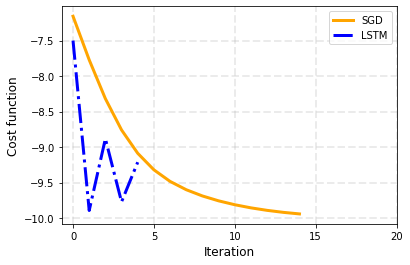

In [32]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color = "orange", lw = 3, label="SGD")

plt.plot(lstm_losses, color = "blue", lw = 3, ls = "-.", label="LSTM")

plt.grid(ls = "--", lw = 2, alpha = 0.25)
plt.legend()
plt.ylabel("Cost function", fontsize = 12)
plt.xlabel("Iteration", fontsize = 12)
ax.set_xticks([0,5,10,15,20]);

See that the custom optimizer based on the LSTM quickly reaches a good value of the loss function, much faster than  standard stochastic gradient descent.

## Loss landscape in parameter space

In [33]:
# Evaluate the cost function on a grid in parameter space
dx = dy = np.linspace(-1., 1., 11)
dz = np.array([new_cost([[xx],[yy]]).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11,11))

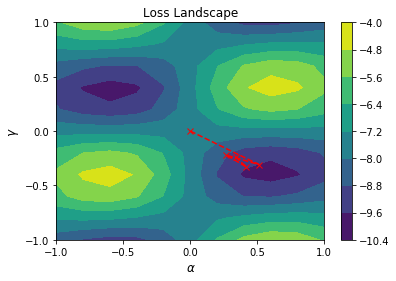

In [34]:
# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Extract optimizer steps
params_x = [0.]+[res[i].numpy()[0,0] for i in range(len(res[:-1]))]
params_y = [0.]+[res[i].numpy()[0,1] for i in range(len(res[:-1]))]
# Plot steps
plt.plot(params_x, params_y, linestyle = "--", color = "red", marker = "x")

plt.yticks(np.linspace(-1,1,5))
plt.xticks(np.linspace(-1,1,5))
plt.xlabel(r"$\alpha$", fontsize = 12)
plt.ylabel(r"$\gamma$", fontsize = 12)
plt.title("Loss Landscape", fontsize = 12)
plt.show()